In [1]:
import os
# Set up environment variables
os.environ["WANDB_API_KEY"] = "5f04d2ce100707f23b71379f67f28901d496edda"
os.environ["WANDB_MODE"] = "disabled"

import argparse
import yaml
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import wandb
import copy

from datasets.dataloaders import get_dataset
from datasets.transforms import data_transform
from utils.loss import gradient_centralization
from models.models_cnn_ae_legacy import C2Model_ConvAutoEncoder_Legacy, C2Loss_ConvAutoEncoder_Legacy

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
info = logger.info

# Argument Parser
parser = argparse.ArgumentParser(description='Autoencoder Training')
parser.add_argument('--yaml', type=str, default="./yaml/cnn_ae/stl10_ccl_legacy.yaml", help='Path to the YAML configuration file')
parser.add_argument('--batchsize', type=int, default=256, help='Batch size')
parser.add_argument('--act_F', type=str, default="elu", help='Forward learning rate')
parser.add_argument('--act_B', type=str, default="elu", help='Backward learning rate')
parser.add_argument('--lr_F', type=float, default=1., help='Forward learning rate')
parser.add_argument('--lr_B', type=float, default=1., help='Backward learning rate')
parser.add_argument('--fw_bn', type=int, default=0, help='Forward batch normalization')
parser.add_argument('--bw_bn', type=int, default=2, help='Backward batch normalization')
parser.add_argument('--mmt_F', type=float, default=0.9, help='Forward batch normalization')
parser.add_argument('--mmt_B', type=float, default=0.9, help='Backward batch normalization')
parser.add_argument('--grad_clip_F', type=float, default=0.5, help='Gradient clipping for forward pass')
parser.add_argument('--grad_clip_B', type=float, default=0.5, help='Gradient clipping for backward pass')
parser.add_argument('--warmup', type=int, default=200, help='Warmup steps')
parser.add_argument('--epochs', type=int, default=100, help='Cosine Annealing T_max')
parser.add_argument('--seed', type=int, default=42, help='Random seed')
parser.add_argument('--filter_target', type=float, default=0.2, help='Filter target')
args, _ = parser.parse_known_args()

with open(args.yaml, 'r') as file:
    yaml_config = yaml.safe_load(file)

# Set default arguments from YAML
parser.set_defaults(**yaml_config['method'])
parser.set_defaults(**yaml_config['dataset'])
parser.set_defaults(**yaml_config['training'])
args, _ = parser.parse_known_args()

args.device = device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
train_loader, val_loader, test_loader = get_dataset(args)

Using Randomcrop, horizontalflip



KeyboardInterrupt



In [ ]:
args.act_F = "relu"
args.act_B = "relu"
args.lr_F = 0.01
args.lr_B = 0.01
args.grad_clip_F = 0.1
args.grad_clip_B = 0.1
args.batchsize = 32
args.method = "BP"
args.fw_bn = 2
args.bw_bn = 2
args.wd_B = 0.0001
args.wd_F = 0.0001

logger.info(args)

# Set up wandb
run_name = f"{args.dataset}_{args.method}_{args.task_transform}"
wandb.init(project="opt-cll-autoencoder", name=run_name, config=args)

# unique run name for saving models, to inlcude dataset, method, task, and transform, lr, act, bn, mmt, grad_clip
unique_run_name = f"{args.dataset}_{args.method}_{args.task_transform}_{args.act_F}_{args.act_B}_{args.fw_bn}_{args.bw_bn}_{args.mmt_F}_{args.mmt_B}_{args.grad_clip_F}_{args.grad_clip_B}"

model = C2Model_ConvAutoEncoder_Legacy(args).to(args.device)
forward_optimizer = optim.SGD(model.forward_params, lr=args.lr_F, momentum=args.mmt_F, weight_decay=args.wd_F)
backward_optimizer = optim.SGD(model.backward_params, lr=args.lr_B, momentum=args.mmt_B, weight_decay=args.wd_B)
if args.tmax !=0:
    forward_scheduler = CosineAnnealingLR(forward_optimizer, T_max=args.tmax, eta_min=args.eta_min)
    backward_scheduler = CosineAnnealingLR(backward_optimizer, T_max=args.tmax, eta_min=args.eta_min)
criterion = C2Loss_ConvAutoEncoder_Legacy(args)
CELoss = nn.CrossEntropyLoss()

for p1, p2 in model.named_parameters():
    if "bn" in p1: p2.requires_grad = True
        
# Training loop
best_val_loss = np.inf
args.train_steps = 0
for args.epoch in range(args.epochs):

    # Training loop
    for batch_idx, (data, target) in enumerate(train_loader):
        model.train()
        if batch_idx > 200: continue
            
        if args.task == "autoencoder":
            data_fw, data_bw = data_transform(args, data)
        elif args.task == "classification":            
            data_fw, data_bw = data, args.T10
        
        if args.method == "CCL":
            activations = model(data_fw.to(args.device), detach_grad=True)
            signals = model.reverse(data_bw.to(args.device), detach_grad=True)
            loss, loss_item = criterion(activations, signals, target.to(args.device), method="local")
        elif args.method == "BP":
            activations = model(data_fw.to(args.device), detach_grad=False)
            loss = F.mse_loss(activations[-1], data_fw.to(args.device))
            loss_item = loss.item()
        if args.train_steps < args.warmup : 
            loss *= (batch_idx+1) / args.warmup
        forward_optimizer.zero_grad(), backward_optimizer.zero_grad()
        loss.backward()
        if args.GradC == 1: gradient_centralization(model)
        if args.grad_clip_F != 0: torch.nn.utils.clip_grad_norm_(model.forward_params, args.grad_clip_F)
        if args.grad_clip_B != 0: torch.nn.utils.clip_grad_norm_(model.backward_params, args.grad_clip_B)
        forward_optimizer.step(), backward_optimizer.step()
        args.train_steps += 1
    if args.tmax !=0:
        forward_scheduler.step(), backward_scheduler.step()

    # Validation loop
    model.eval()
    val_loss, val_loss_B, val_counter = 0, 0, 0
    val_acc = 0
    with torch.no_grad():
        for data, target in val_loader:
            if args.task == "autoencoder":
                data_fw, data_bw = data_transform(args, data)
            elif args.task == "classification":            
                data_fw, data_bw = data, args.T10
            if args.method == "CCL":
                activations = model(data_fw.to(args.device), detach_grad=True)
                signals = model.reverse(data_bw.to(args.device), detach_grad=True)
                loss = F.mse_loss(activations[-1], signals[-1]).item()
            elif args.method == "BP":
                activations = model(data_fw.to(args.device), detach_grad=True)
                loss_item = F.mse_loss(activations[-1], data_fw.to(args.device)).item()
            val_counter += len(data)
            val_loss += loss * len(data)

    logger.info(f"Epoch {args.epoch} | Loss: {val_loss / val_counter:.4f}")
    wandb.log({"val_loss": val_loss / val_counter})

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_epoch = args.epoch
        logger.info(f"Best model found at epoch {best_epoch}")

# Test loop
model = best_model
model.eval()
test_loss, test_counter = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        if args.task == "autoencoder":
            data_fw, data_bw = data_transform(args, data)
        elif args.task == "classification":            
            data_fw, data_bw = data, args.T10
        if args.method == "CCL":
            activations = model(data_fw.to(args.device), detach_grad=True)
            signals = model.reverse(data_bw.to(args.device), detach_grad=True)
            loss = F.mse_loss(activations[-1], signals[-1]).item()
        elif args.method == "BP":
            activations = model(data_fw.to(args.device), detach_grad=True)
            loss = F.mse_loss(activations[-1], data_fw.to(args.device)).item()
        test_counter += len(data)
        test_loss += loss * len(data)
wandb.log({"test_loss": test_loss / test_counter})
# save the best model using unique_run_name
# save_path = f"./results/cnn_ae_models/{unique_run_name}.pt"
# torch.save(best_model.state_dict(), save_path)

In [18]:
ccl_model = C2Model_ConvAutoEncoder_Legacy(args).to(args.device)
bp_model = C2Model_ConvAutoEncoder_Legacy(args).to(args.device)

ccl_model.load_state_dict(torch.load("./results/cnn_ae_models/STL10_CCL_same_relu_relu_2_2_0-Copy1.9_0.9_0.1_0.1.pt"))
bp_model.load_state_dict(torch.load("./results/cnn_ae_models/STL10_BP_same_relu_relu_2_2_0-Copy1.5_0.0_0.3_0.3.pt"))

<All keys matched successfully>

In [40]:
data.max()

tensor(1.)

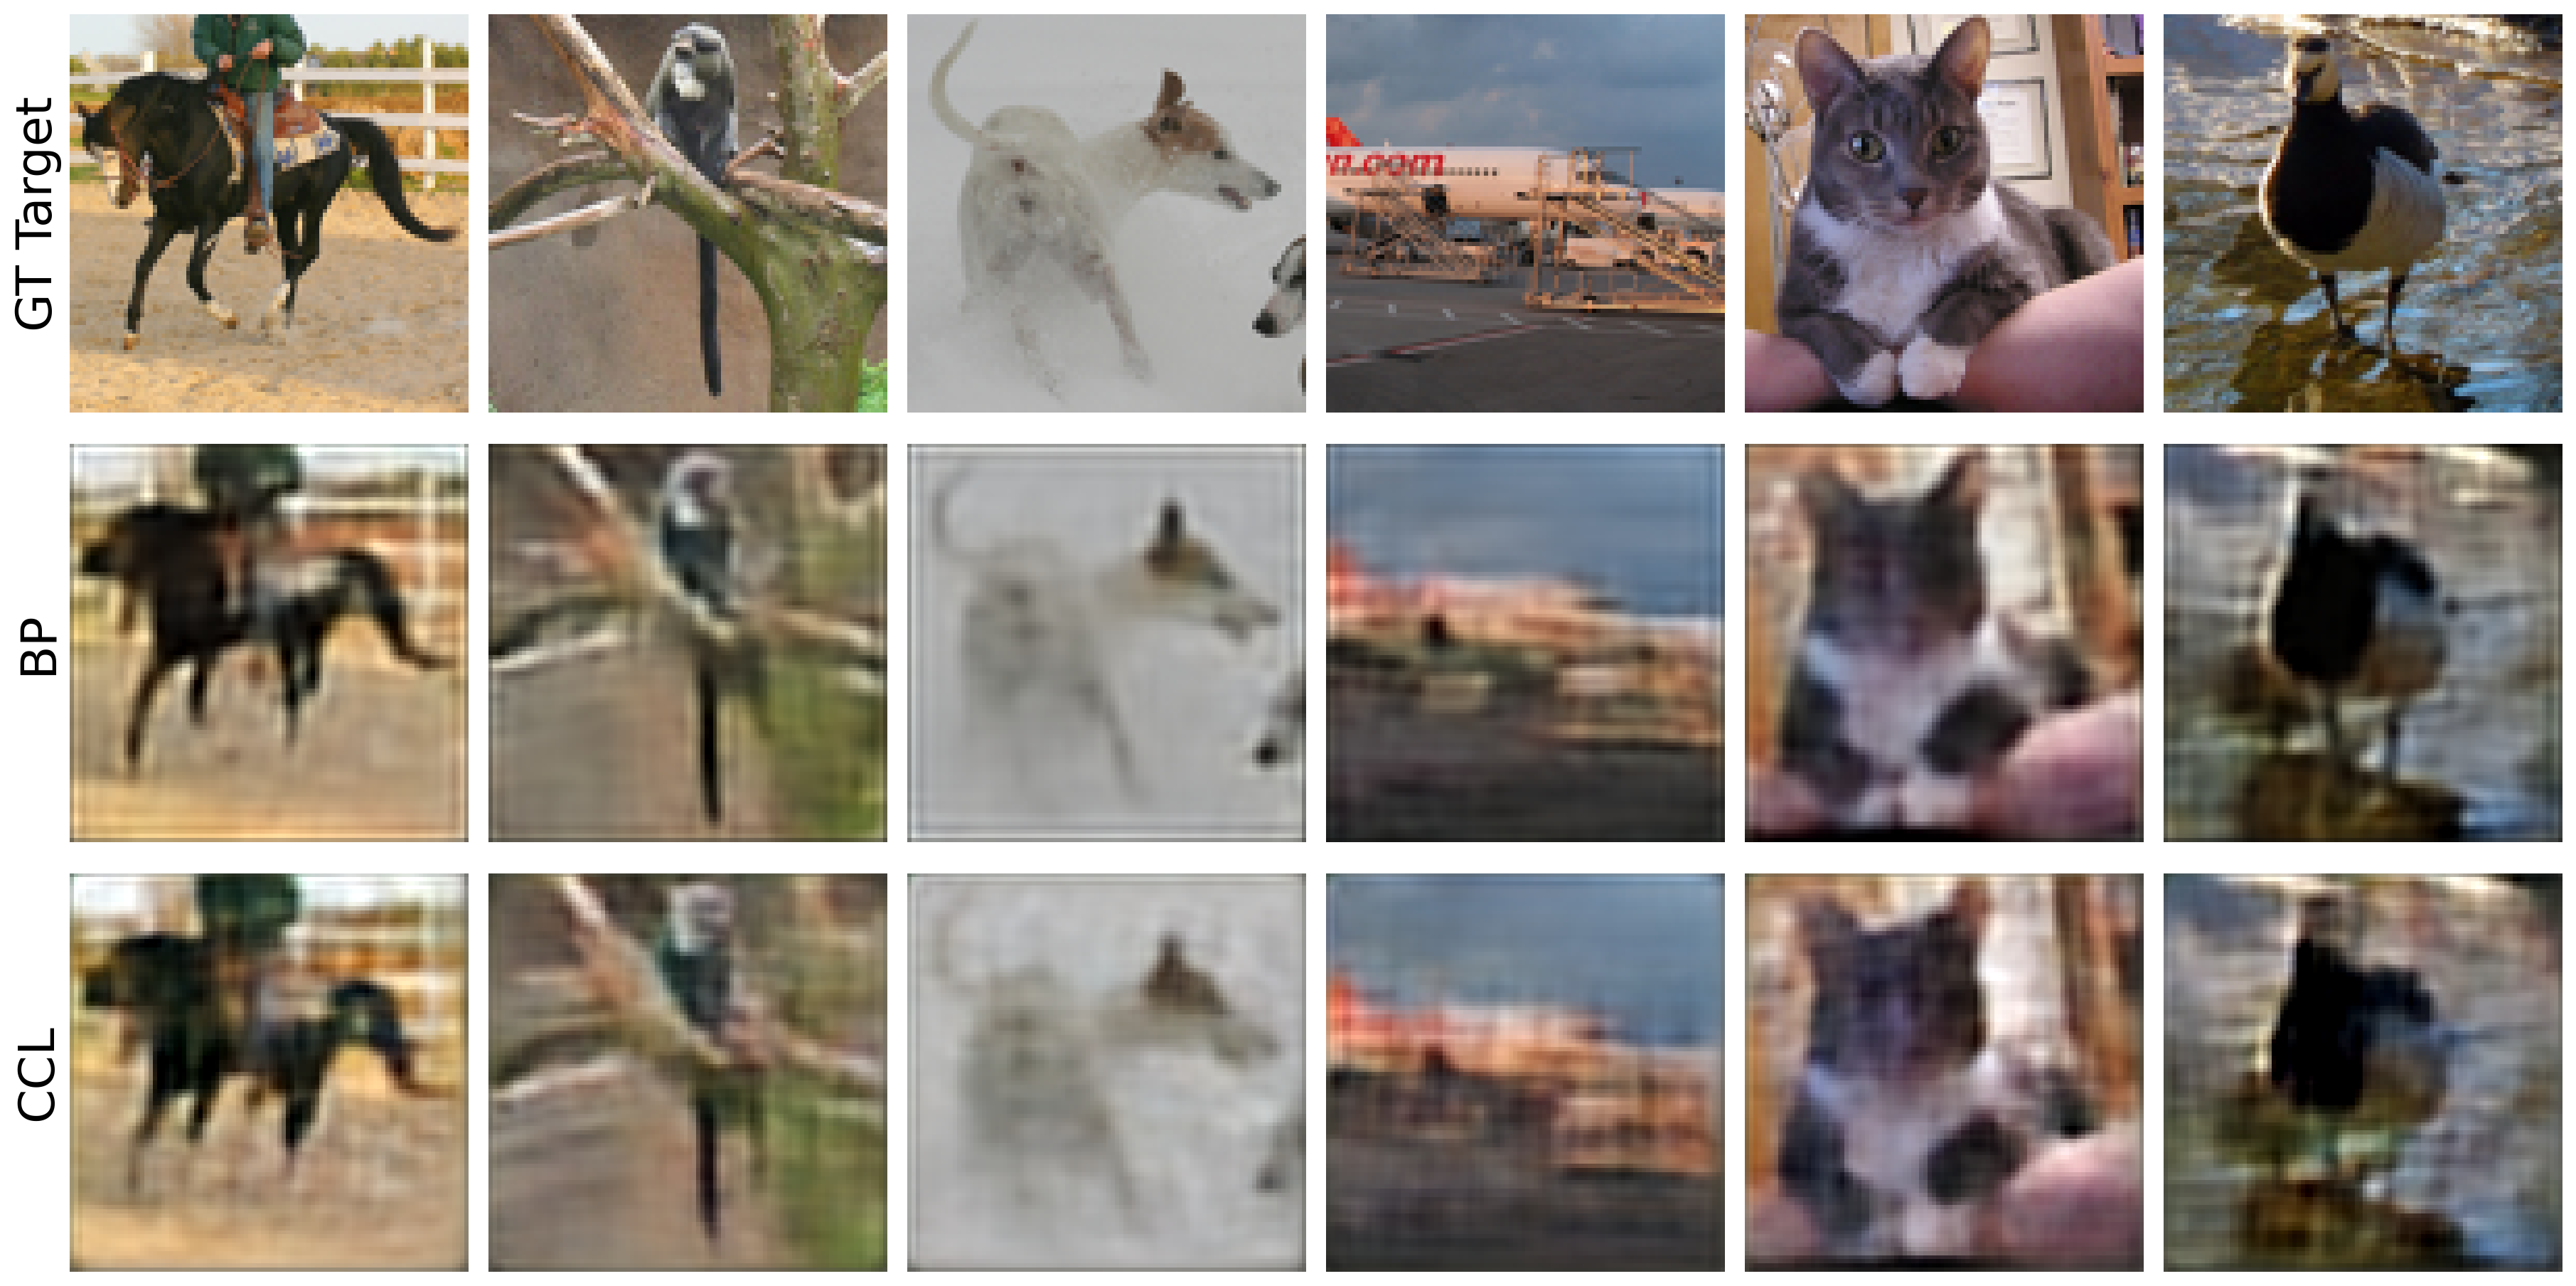

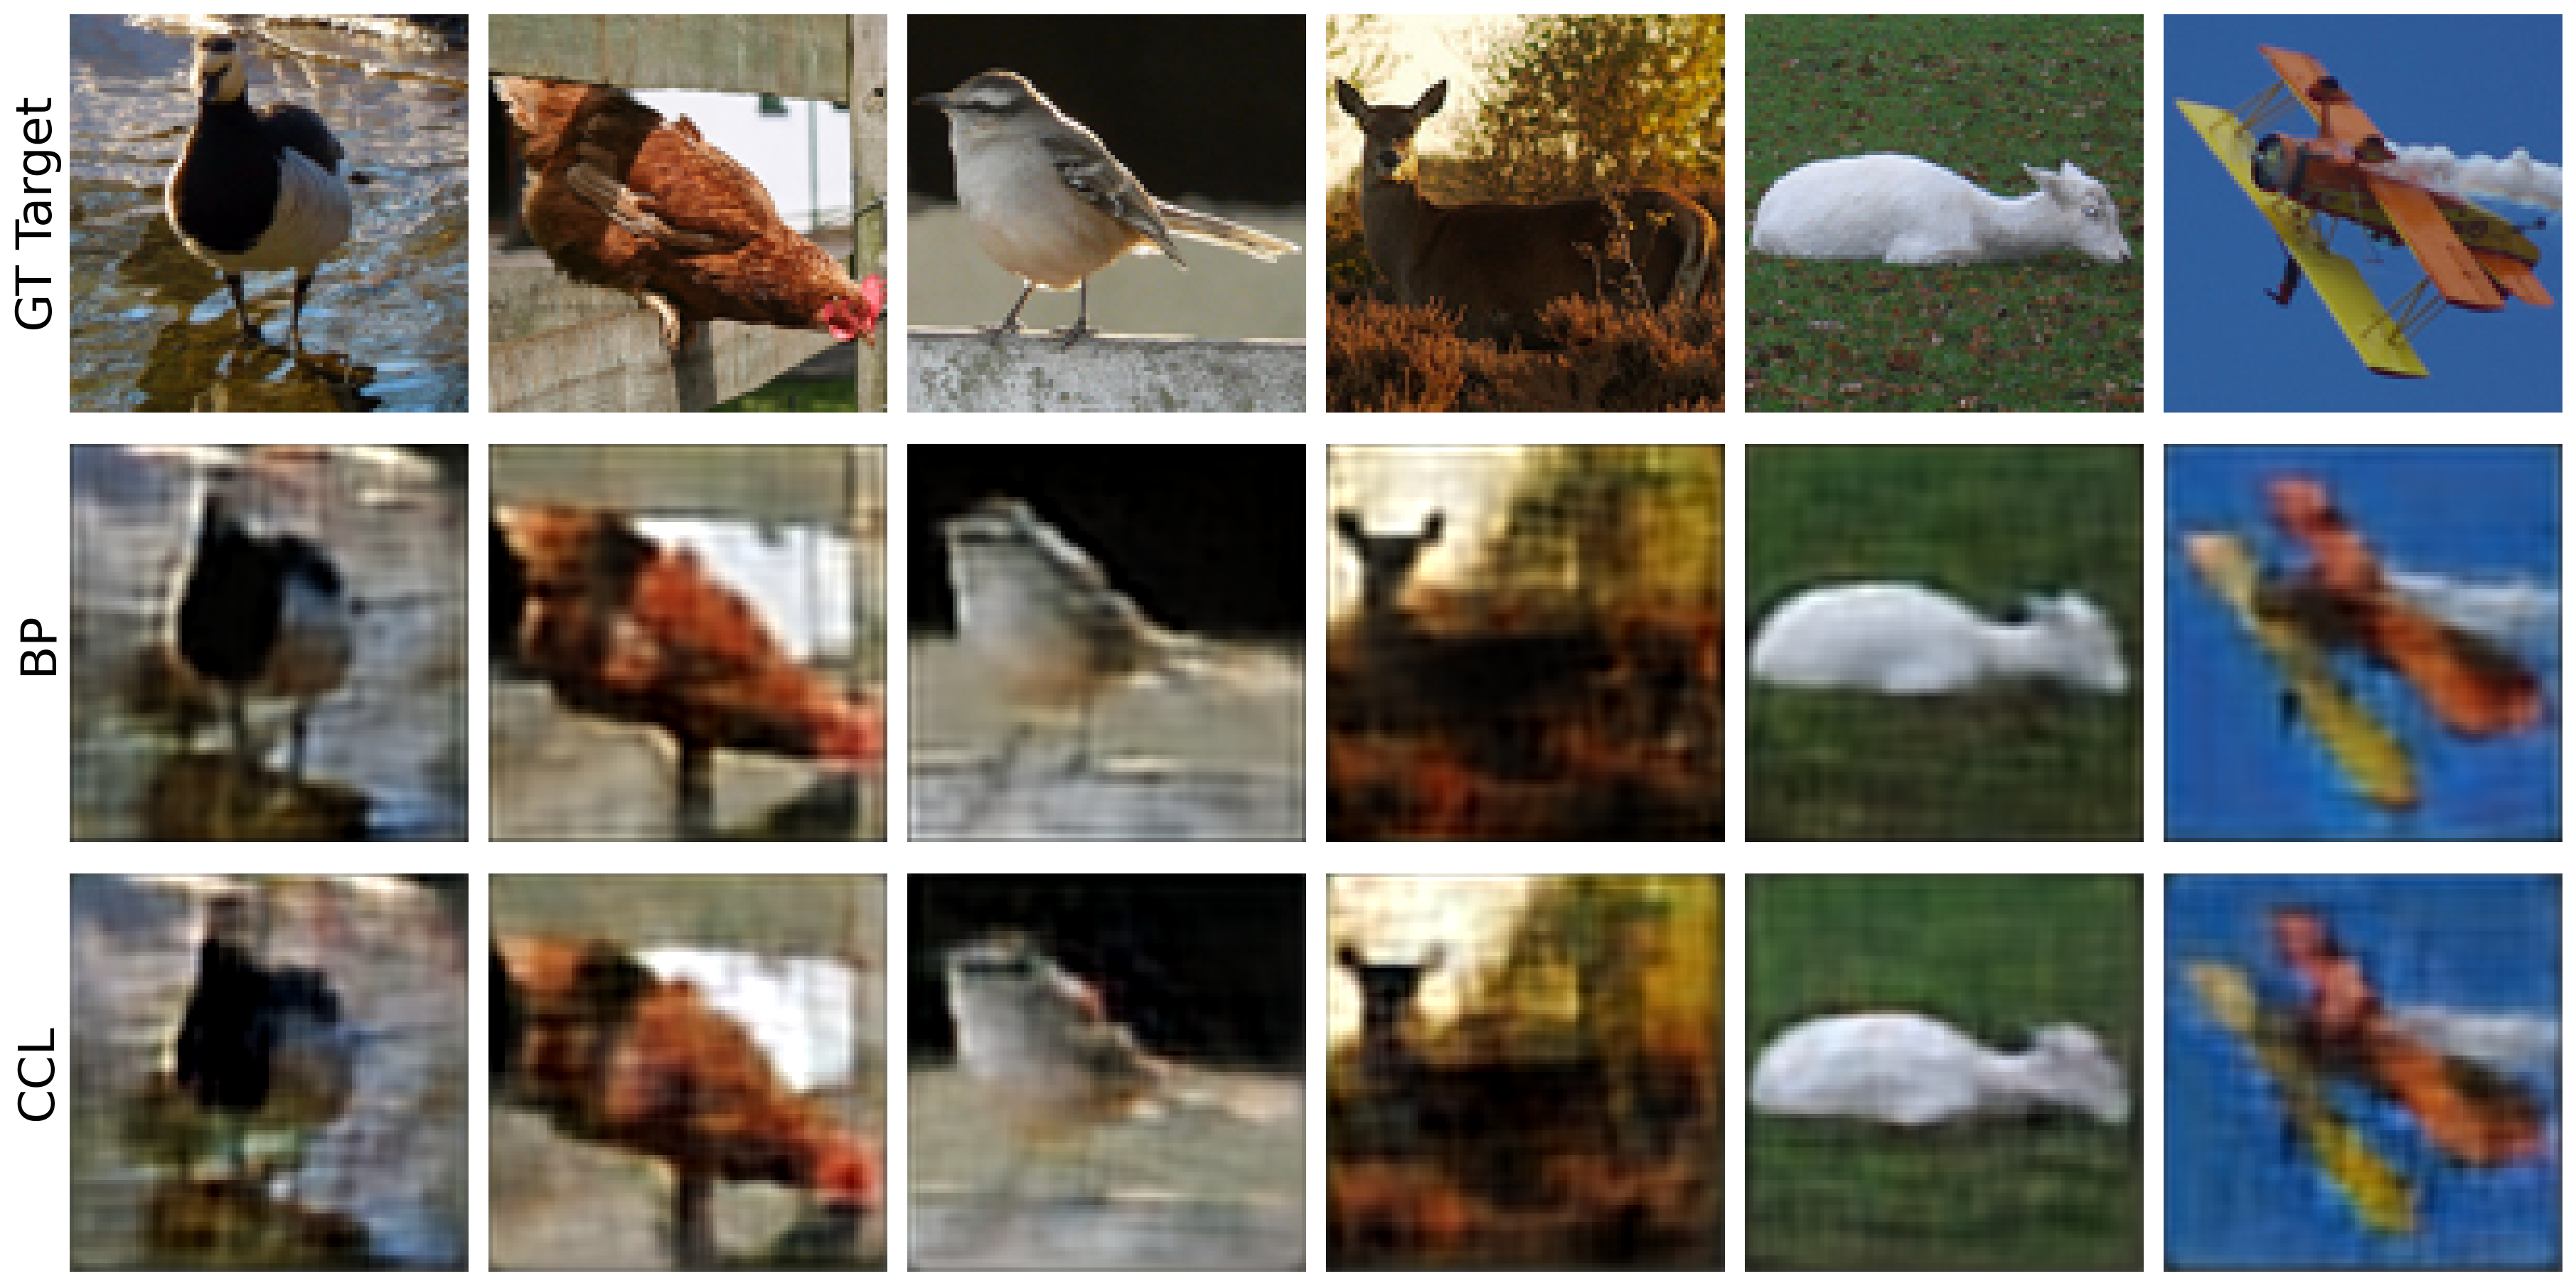

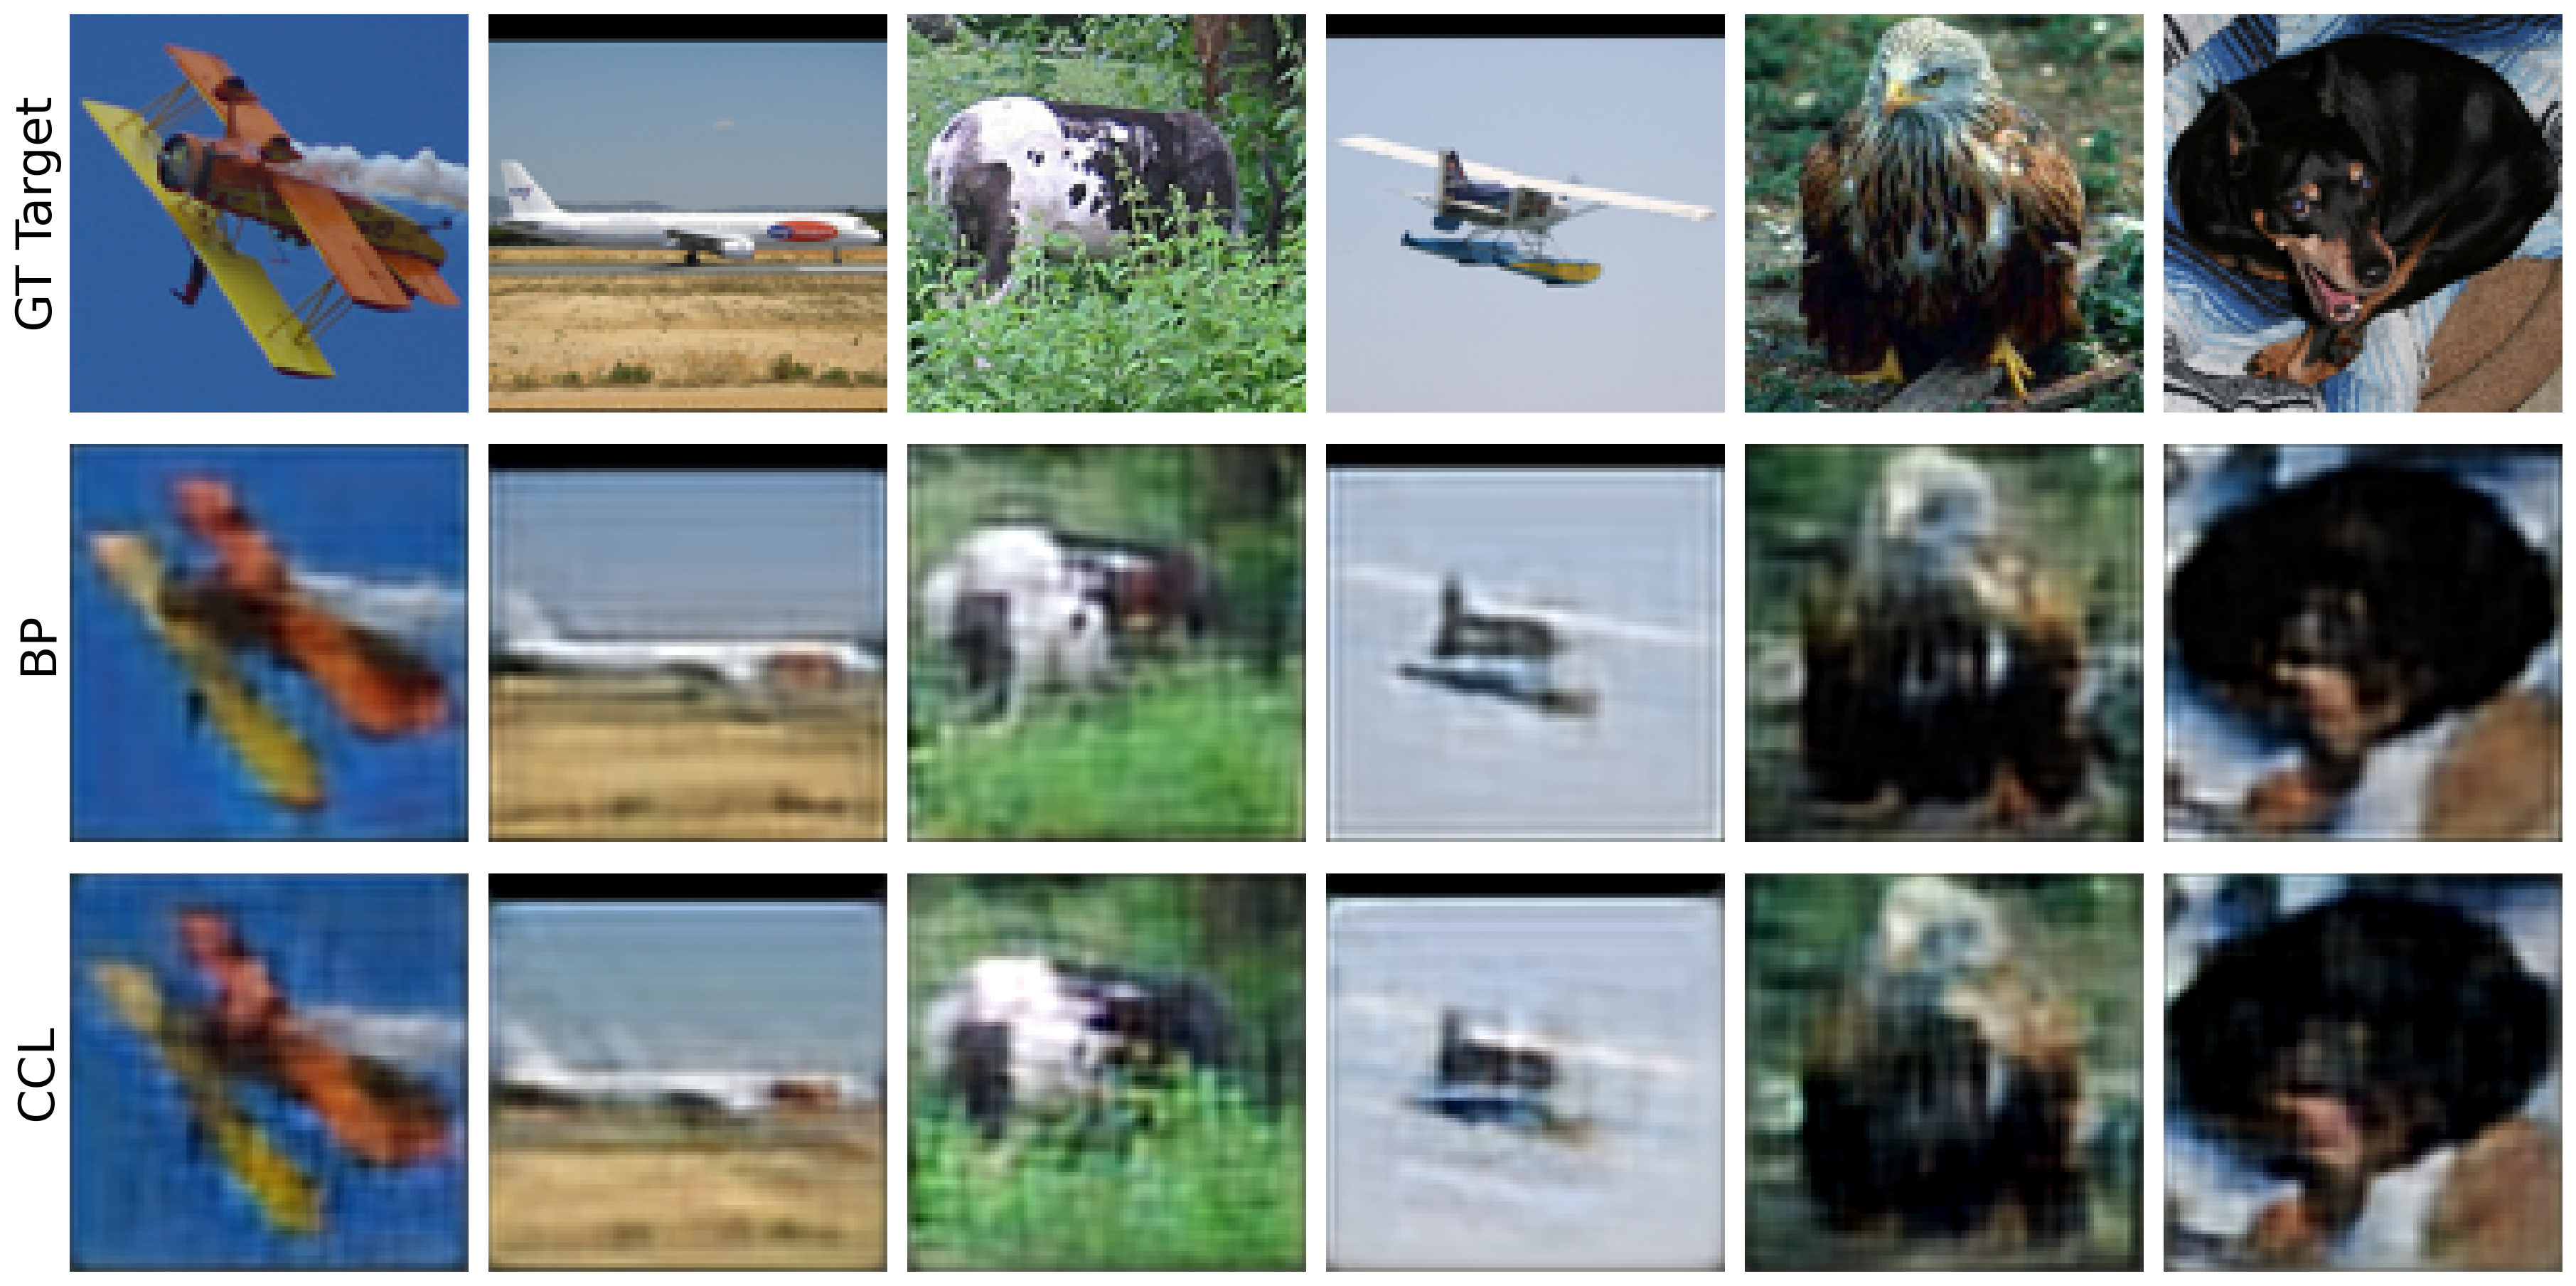

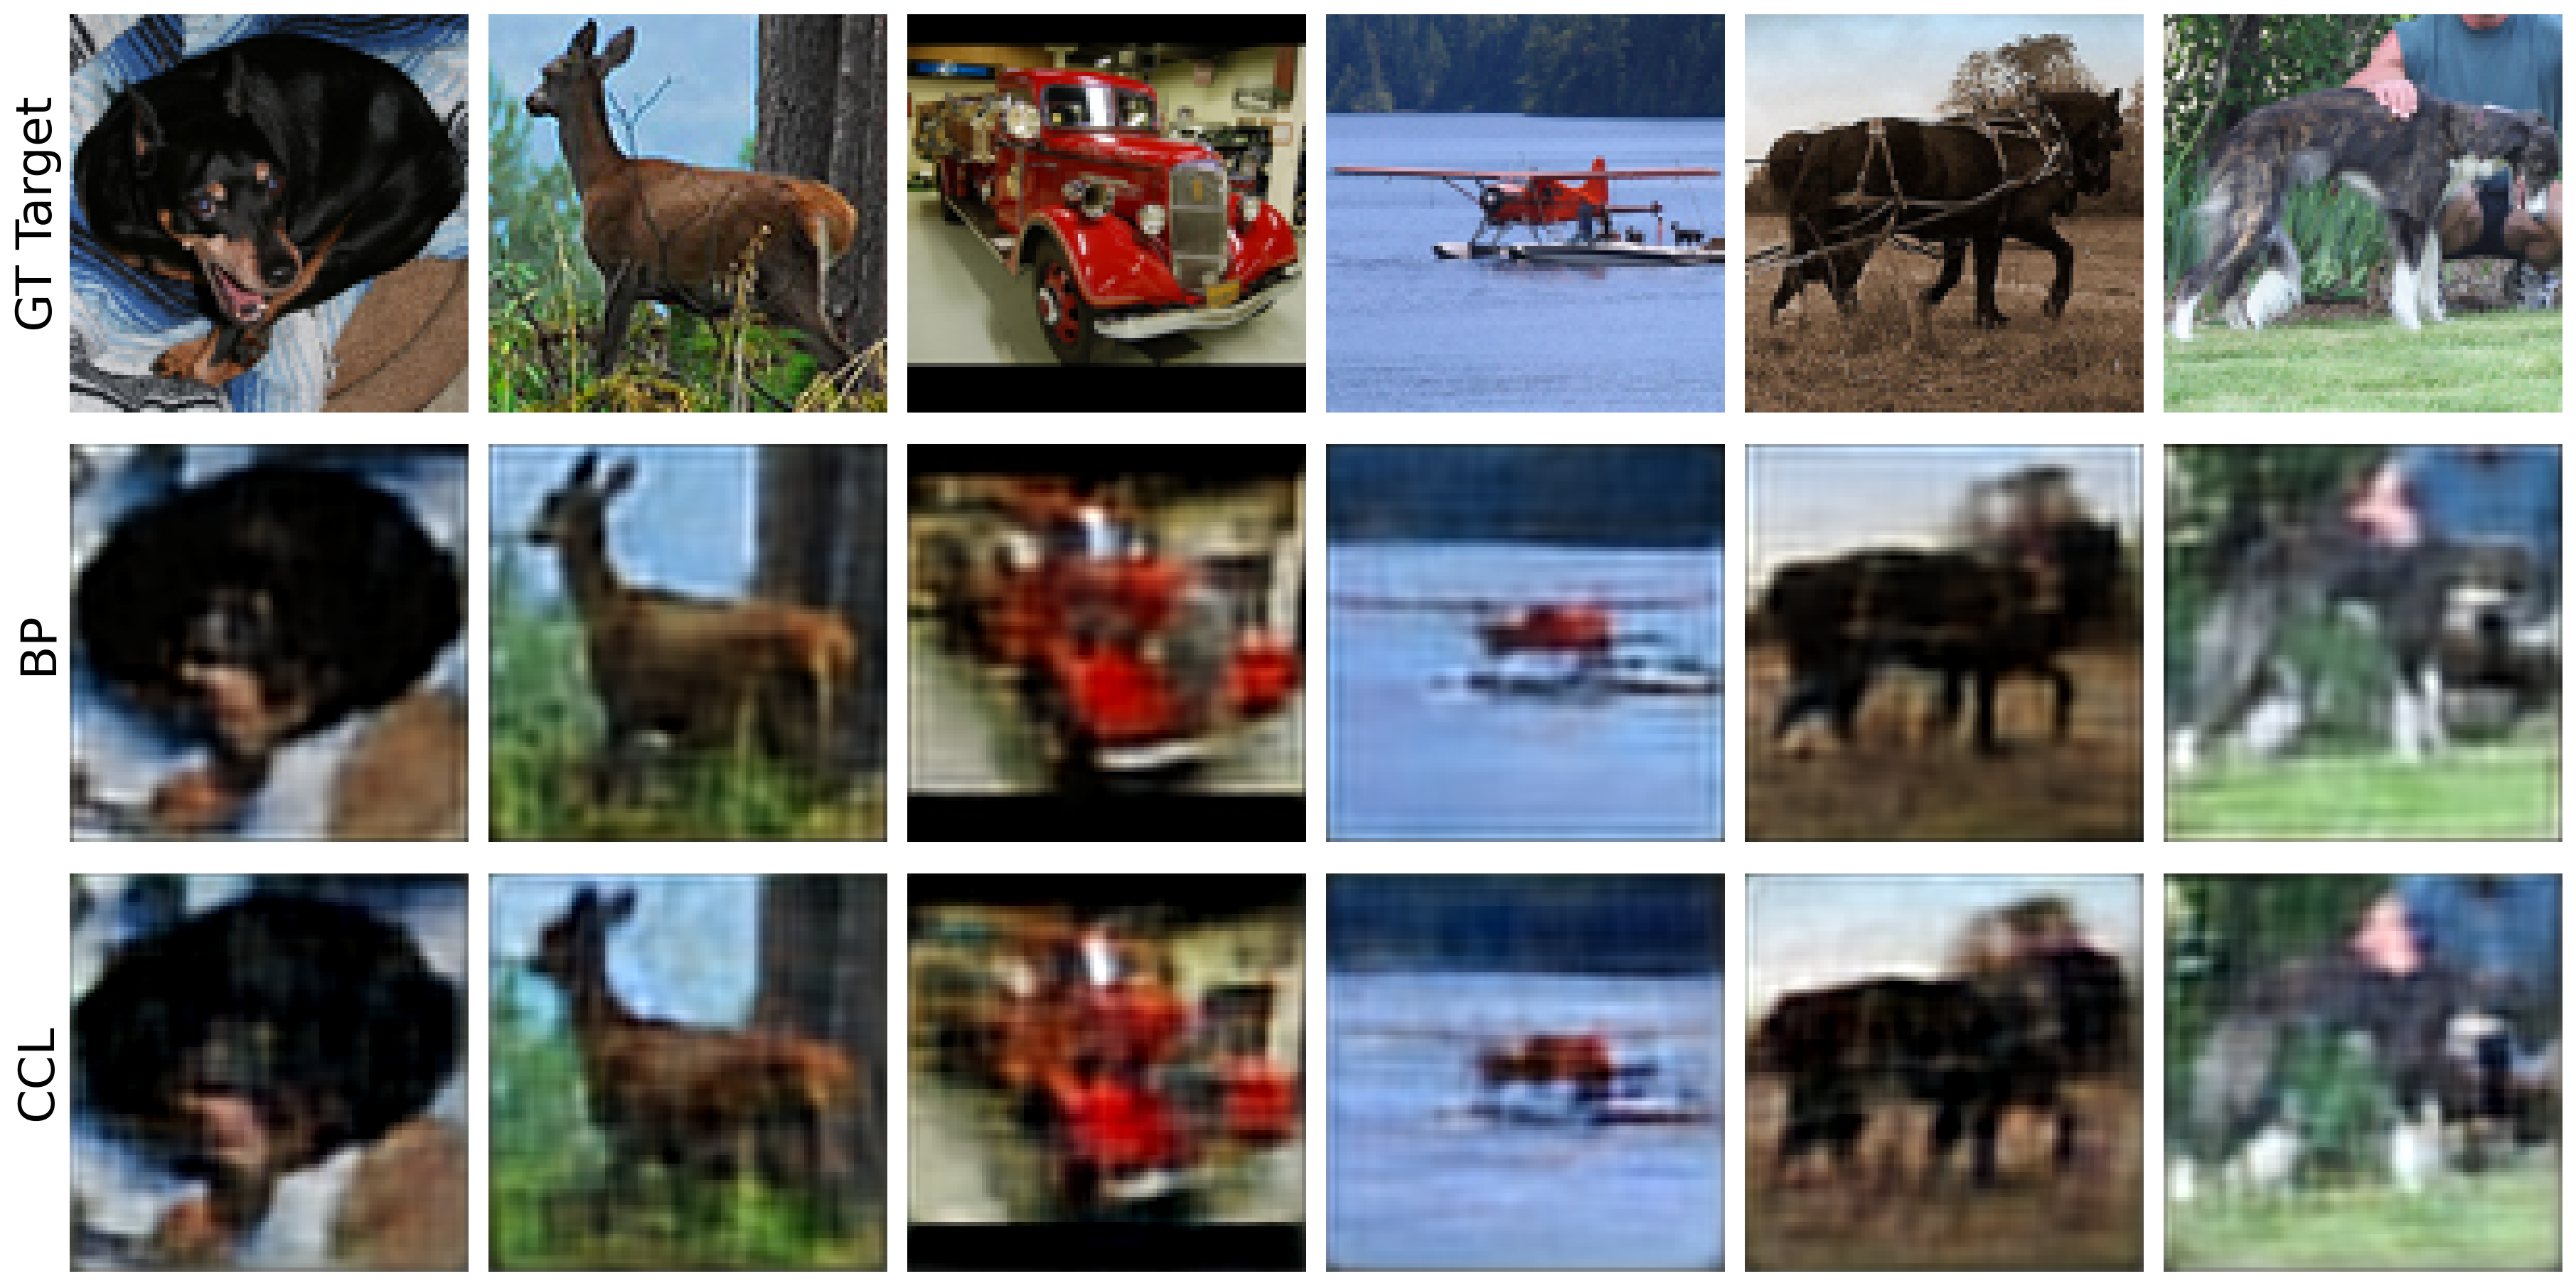

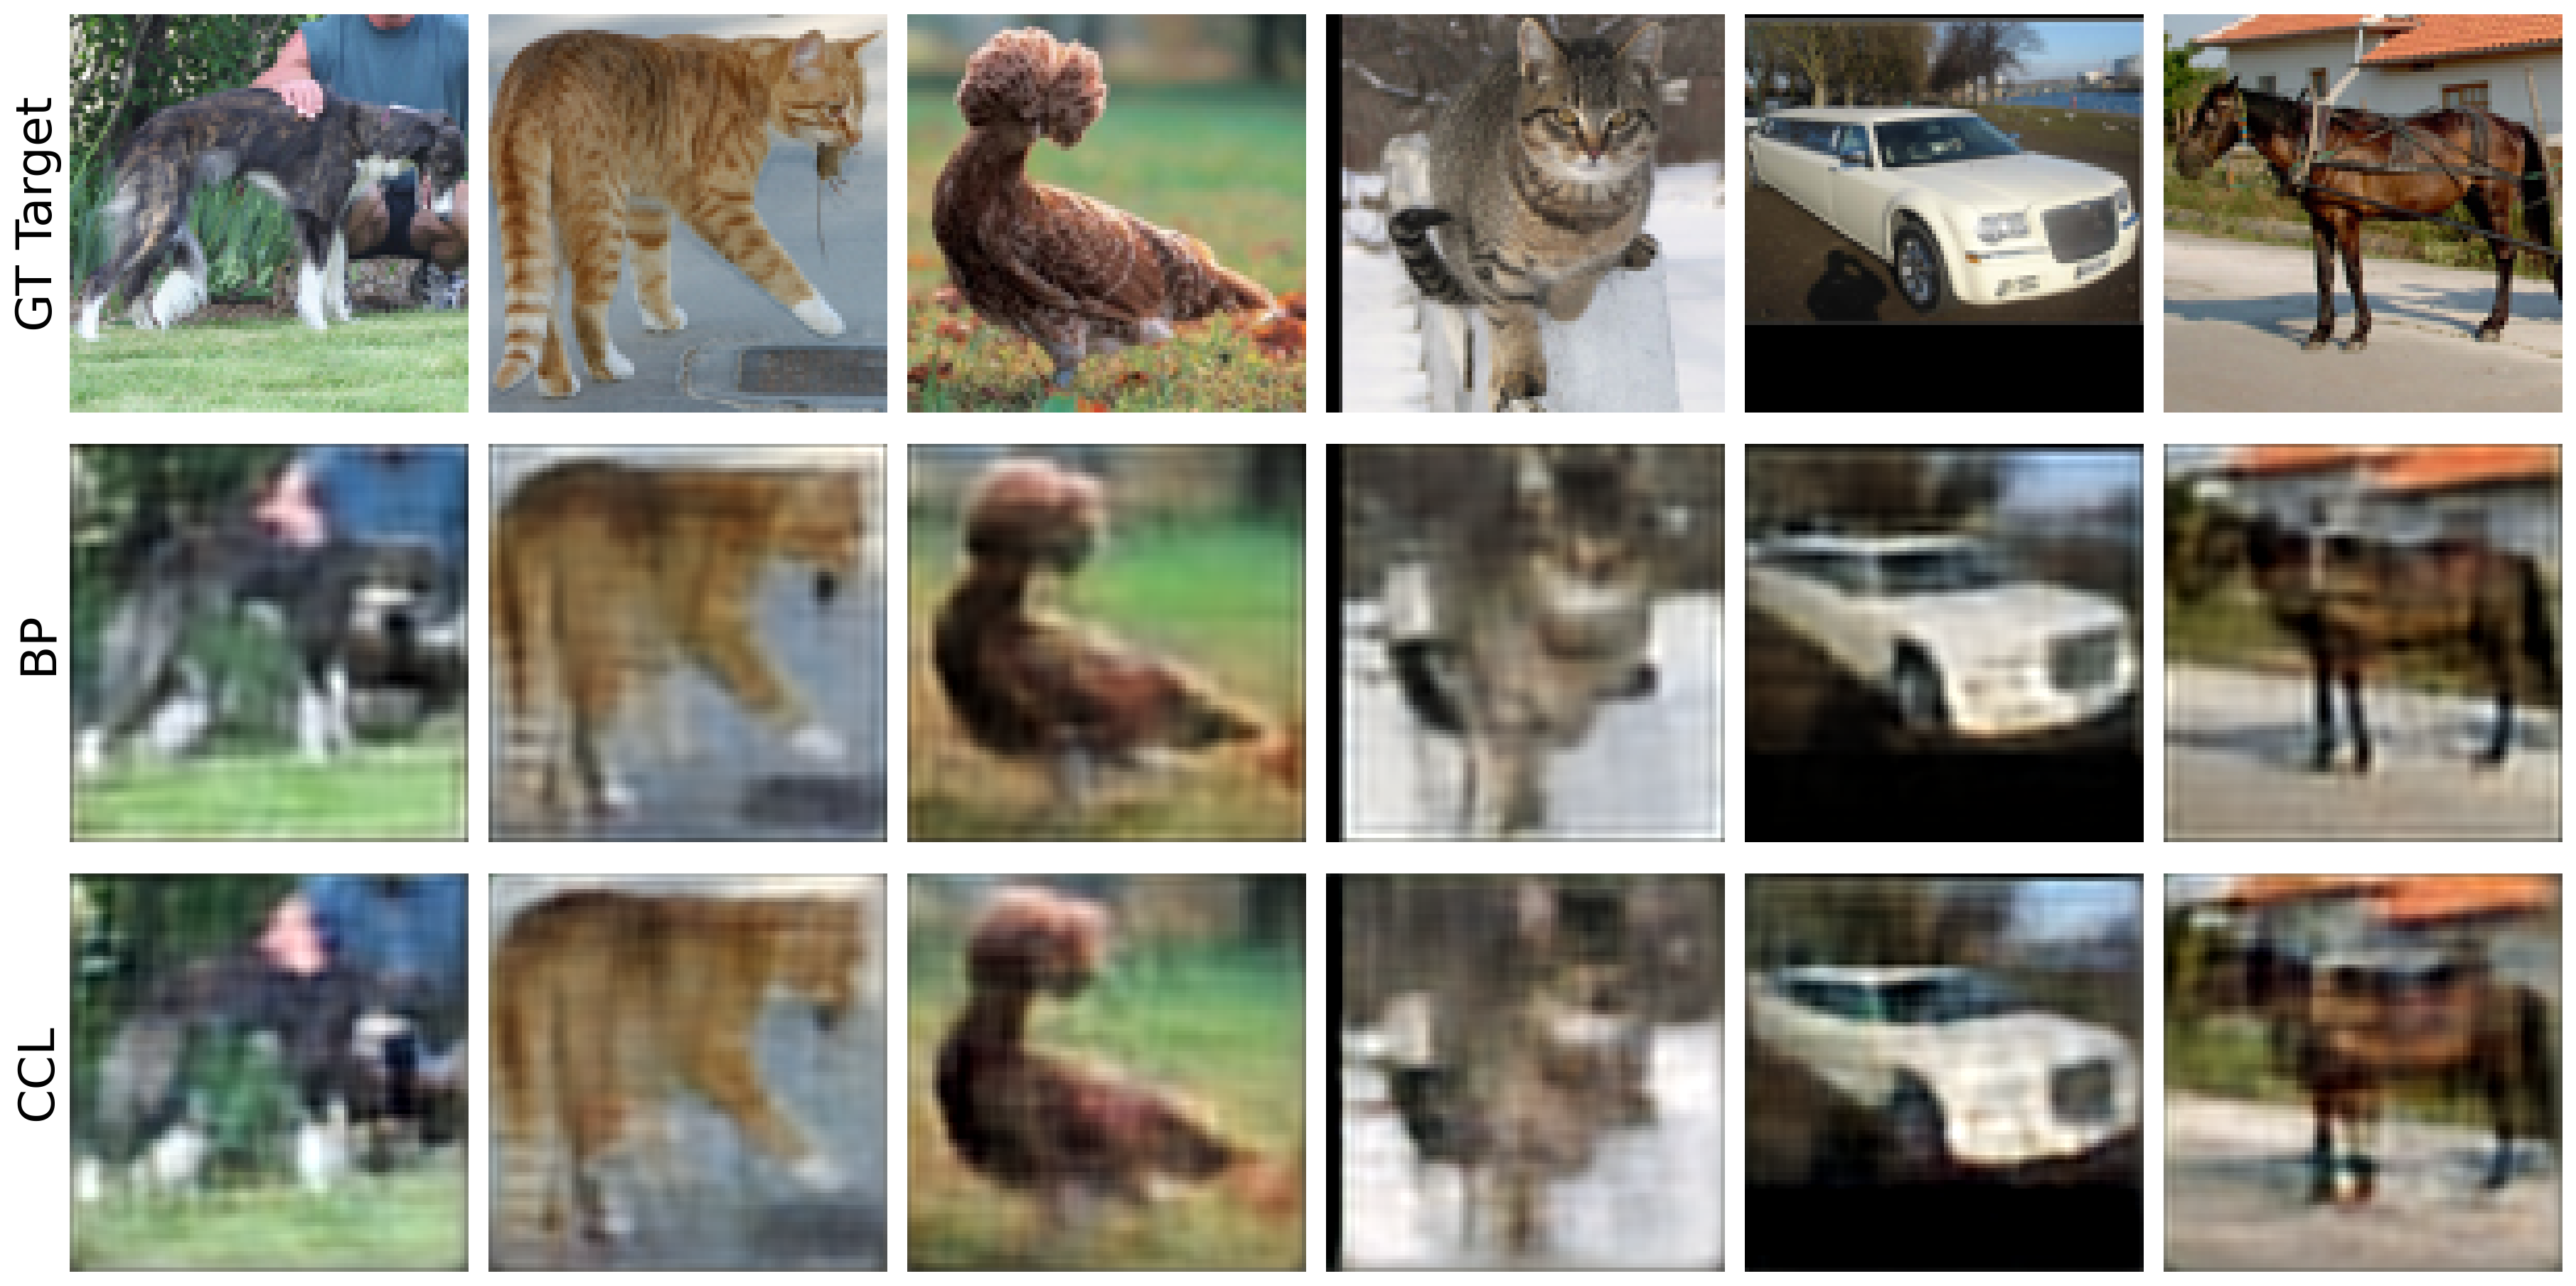

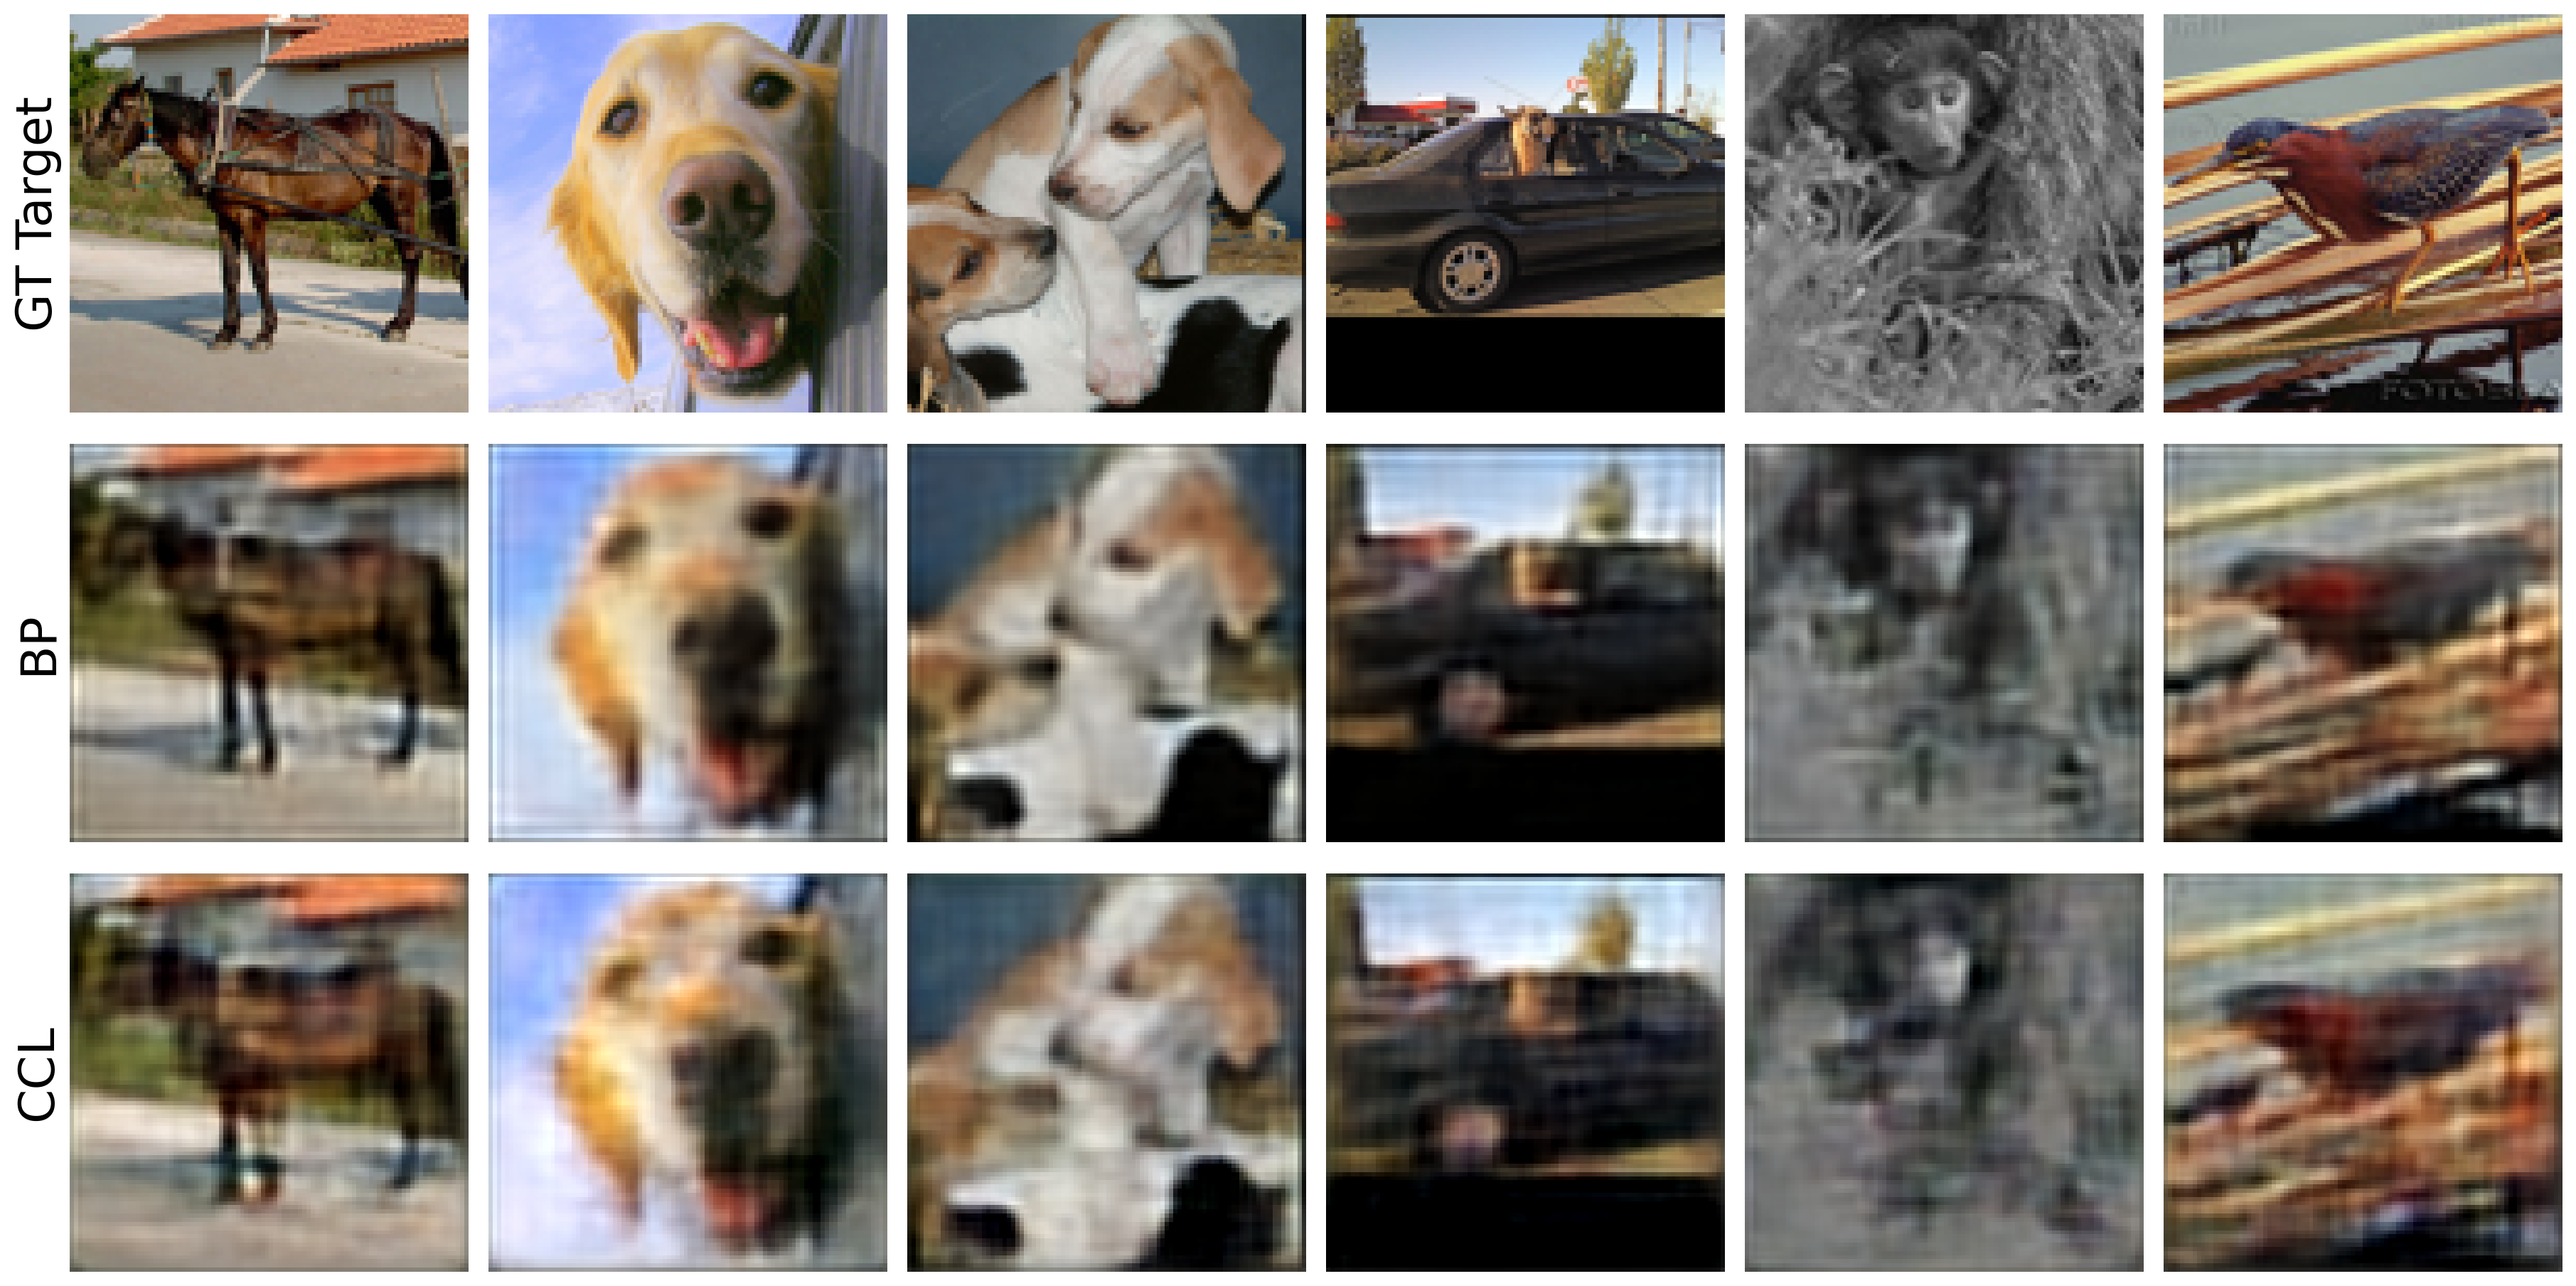

IndexError: index 32 is out of bounds for dimension 0 with size 32

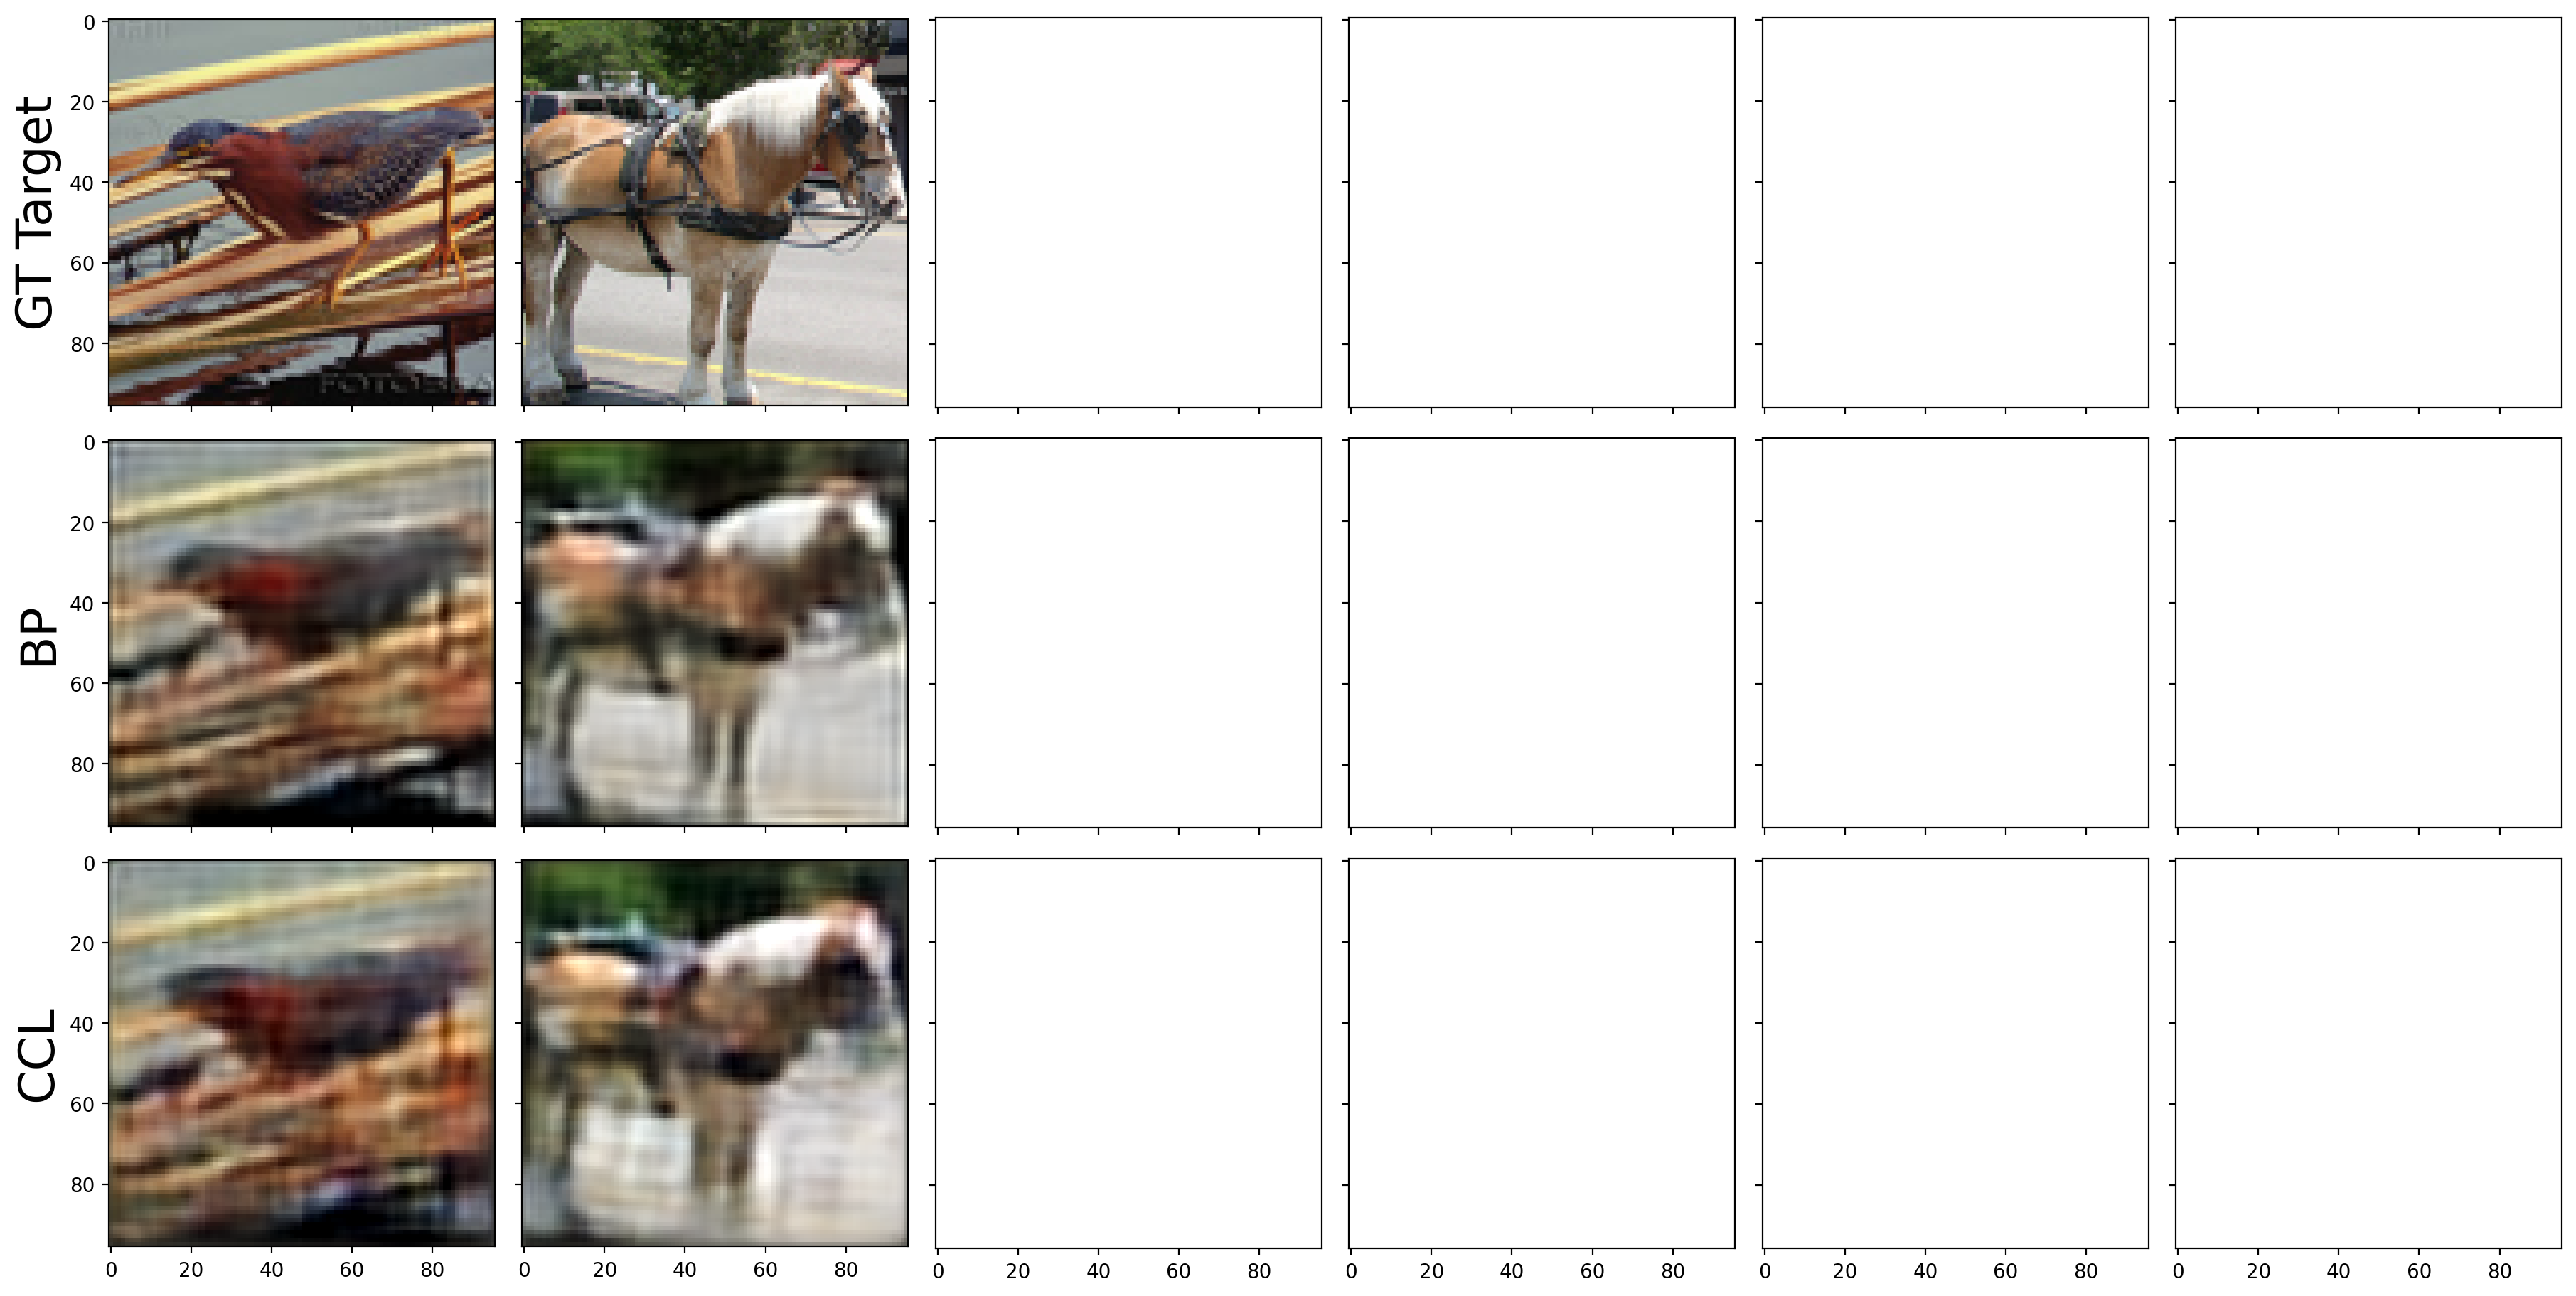

In [37]:
for data, target in test_loader: break
data_fw, data_bw = data_transform(args, data)

ccl_activations = ccl_model(data_fw.to(device), detach_grad=True)
ccl_signals = ccl_model.reverse(data_bw.to(device), detach_grad=True)

bp_activations = bp_model(data_fw.to(device), detach_grad=True)
bp_signals = bp_model.reverse(data_bw.to(device), detach_grad=True)

data_fw = torch.clip(data_fw.permute(0,2,3,1), 0, 1)
data_bw = torch.clip(data_bw.permute(0,2,3,1), 0, 1)
ccl_acts = torch.clip(ccl_activations[-1].permute(0,2,3,1), 0, 1)
ccl_sigs = torch.clip(ccl_signals[0].permute(0,2,3,1), 0, 1)
bp_acts = torch.clip(bp_activations[-1].permute(0,2,3,1), 0, 1)
bp_sigs = torch.clip(bp_signals[0].permute(0,2,3,1), 0, 1)

n_col = 6
for idx_set in range(8):
    fig, axes = plt.subplots(3,n_col,dpi=200,figsize=(n_col*3,9),
                             sharex=True,sharey=True,constrained_layout=True)
    for j in range(n_col):
        idx = j+idx_set*5
        axes[0,j].imshow(data_fw[idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        axes[1,j].imshow(bp_acts[idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        axes[2,j].imshow(ccl_acts[idx].detach().cpu().numpy(), vmin=0, vmax=1, cmap="gray")
        if j == 0:
            axes[0,0].set_ylabel("GT Target", size=25)
            axes[1,0].set_ylabel("BP", size=25)
            axes[2,0].set_ylabel("CCL", size=25)
    for ax in axes.flatten(): ax.set_xticks([]), ax.set_yticks([]), ax.set_frame_on(False)

#     save the figures using unique_run_name
    plt.savefig(f"./results/cnn_ae_models/exp_cnn_ae_vis_set{idx_set}.pdf")
    plt.pause(1)
    plt.close()

#     break

In [11]:
bp_sigs[idx].min()

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

In [14]:
bp_signals[0].max()

tensor(0.0271, device='cuda:0', grad_fn=<MaxBackward1>)